## Iso-mirror analysis on the POLECAT data

First, we import the library `dmprdpg`.

In [1]:
import dmprdpg

In [2]:
import matplotlib.pyplot as plt
## Compile with tikz and times font
plt.rc('text', usetex=True)
plt.rc('font', family='times')

Next, import the POLECAT data and related mapping files. 

In [3]:
import pandas as pd
import numpy as np

# Load the dataframe from the CSV file
df = pd.read_csv('../data/polecat/polecat.csv')
map_country = pd.read_csv('../data/polecat/map_country.csv', header=None)
map_month = pd.read_csv('../data/polecat/map_month.csv', header=None)
map_event_type = pd.read_csv('../data/polecat/map_event_type.csv', header=None)
map_quad_code = pd.read_csv('../data/polecat/map_quad_code.csv', header=None)

# Print the number of rows and columns
N = len(map_country)
K = len(map_event_type)
print('Number of countries:', N)
print('Number of event types:', K)

Number of countries: 199
Number of event types: 16


Consider only a subset of months with a sufficient number of events.

In [4]:
# Count how many times each 'Event Month Id' occurs
count = df['Event Month Id'].value_counts()
# Calculate edge density per month
subset_times = np.sort(list(count[count / (N * (N - 1) / 2) / len(map_event_type) > 0.05].index))
# Number of time points
T = len(subset_times)
print('Number of time points:', T)

Number of time points: 16


In [5]:
subset_times

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

Filter out countries that were observed very sparingly. 

In [6]:
# Filter out countries that were observed very sparingly
Q = ((df['Actor Country'].value_counts() + df['Recipient Country'].value_counts()) > 5 * K * len(map_month))
# Get row names where Q is True
subset_countries = Q[Q].index
N = len(subset_countries)
# Filter df to only include rows where the Actor Country and Recipient Country are in subset_countries
df = df[df['Actor Country'].isin(subset_countries) & df['Recipient Country'].isin(subset_countries)]
print('Total number of events:', len(df))
# Print N
print('Number of countries:', N)

Total number of events: 624888
Number of countries: 104


Use `Event Type` first for the graph construction. Next, the analysis will be repeated with `Quad Code`. Establish the mapping between these codes in `map_event_type`:

In [7]:
# Extract the unique 'Quad Code' for each 'Event Type' and add as an additional column to map_event_type
quad_code_dict = df.groupby('Event Type')['Quad Code'].first().to_dict()
quad_code_dict_id = df.groupby('Event Type')['Quad Code Id'].first().to_dict()
# Add the mapping to map_event_type
map_event_type[2] = map_event_type[0].map(quad_code_dict)
map_event_type[3] = map_event_type[0].map(quad_code_dict_id)

Map countries to integers based on the subset of countries filtered above. 

In [8]:
# Map elements subset_countries to consecutive integers, then use map_countries to map back to the original country ID
map_country = {subset_countries[i]: i for i in range(len(subset_countries))}
df['Actor Country Id'] = df['Actor Country'].map(map_country)
df['Recipient Country Id'] = df['Recipient Country'].map(map_country)
# Transform map_countries into a DataFrame
map_country = pd.DataFrame(list(map_country.items()), columns=['Country', 'Country ID'])

Construct adjacency matrices for each pair `(Event Type, Month)`. 

In [9]:
from scipy.sparse import csr_matrix

# Create the dictionary to hold the sparse matrices
A_dict = {}

# Loop over the unique combinations
for event_month_id in subset_times:
    for event_type_id in range(K):
        # Filter the DataFrame for the current combination
        filtered_df = df[(df['Event Month Id'] == event_month_id) & (df['Event Type Id'] == event_type_id)]
        # Create a pivot table
        rows = list(filtered_df['Actor Country Id'])
        columns = list(filtered_df['Recipient Country Id'])
        values = [1.] * len(filtered_df)
        # Convert the pivot table to a sparse matrix
        sparse_matrix = csr_matrix((values, (rows, columns)), shape=(N, N))
        # Add the sparse matrix to the dictionary
        A_dict[(event_type_id, event_month_id-3)] = sparse_matrix 

Calculate the DUASE from the adjacency matrices, using the function `duase` in `dmprdpg`. 

In [10]:
S = dmprdpg.singular_values_A_tilde(A_dict, K=K, T=T, d_max=A_dict[0,0].shape[0]-1)
d = dmprdpg.eigengap(S, x=2)[-1]
print('Estimated dimension:', d)

Estimated dimension: 4


In [11]:
X, Y = dmprdpg.duase(A_dict, K=K, T=T, d=d)

Plot the output of DUASE.

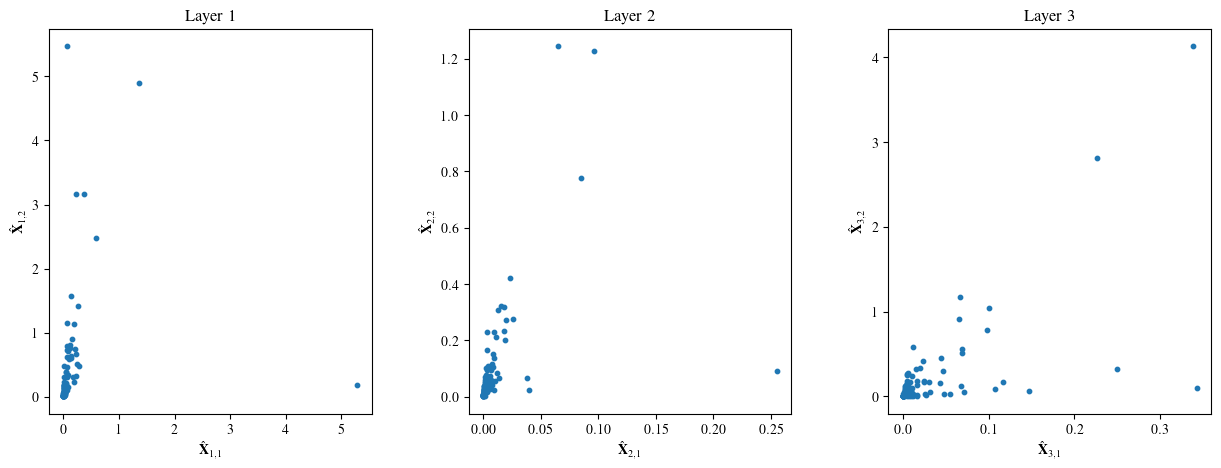

In [12]:
## Plot all layers in different subfigures
fig, axs = plt.subplots(1,3, figsize=(15, 5))
## Slightly augment distance between subfigures
plt.subplots_adjust(wspace=0.3)
for k in range(3):
    axs[k].scatter(X[:,0,k], X[:,1,k], s=10)
    axs[k].set_title(f"Layer {k+1}")
    ## Axis labels
    axs[k].set_xlabel(r"$\hat{\mathbf{X}}_{" + str(k+1) + ",1}$")
    axs[k].set_ylabel(r"$\hat{\mathbf{X}}_{" + str(k+1) + ",2}$")
plt.show()

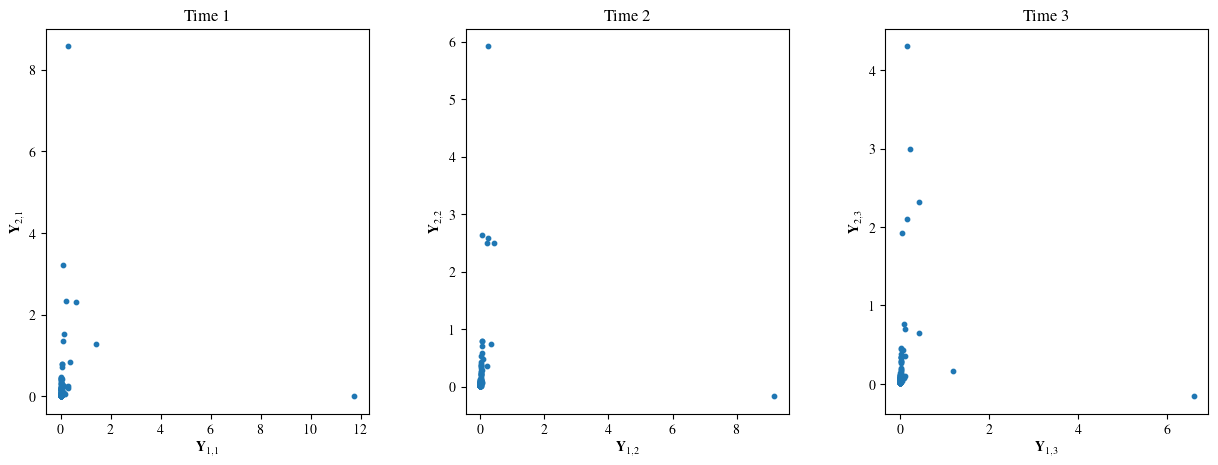

In [13]:
## Repeat for different times
fig, axs = plt.subplots(1,3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)
for t in range(3):
    axs[t].scatter(Y[:,0,t], Y[:,1,t], s=10)
    axs[t].set_title(f"Time {t+1}")
    axs[t].set_xlabel(r"$\mathbf{Y}_{1," + str(t+1) + "}$")
    axs[t].set_ylabel(r"$\mathbf{Y}_{2," + str(t+1) + "}$")
plt.show()

Apply the `isomirror` function on the left embedding $\hat{\mathbf{X}}^k,\ k=1,\dots,K$, and plot.

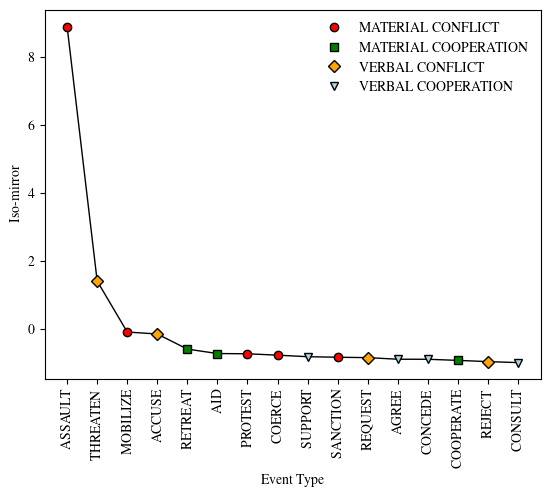

In [14]:
V = dmprdpg.mirror(X, n_components_cmds=2, n_components_isomap=1, n_neighbors=10)
V_vals = np.sort(V[:,0])[::-1]
V_keys = np.array(map_event_type[0][np.argsort(V[:,0])[::-1]])
V_cols = list(map_event_type[3][np.argsort(V[:,0])[::-1]])
colours = ['red', 'green', 'orange', 'lightblue']
markers = ['o', 's', 'D', 'v'] 
plt.plot(np.arange(K), V_vals, color='black', lw=1)
## Loop over all points and use different colours and markers for different event types
for i in range(K):
    plt.plot(i, V_vals[i], marker=markers[V_cols[i]], color='black', markerfacecolor=colours[V_cols[i]])
## Dummy plot to create legend
qcs = np.unique(np.array(map_event_type[[2,3]], dtype=str), axis=0)
for i in range(len(qcs)):
    num = int(qcs[i,1])
    plt.plot([], [], marker=markers[num], color='black', markerfacecolor=colours[num], label=qcs[i,0], lw=0)
# Display the legend
plt.legend(frameon=False, loc='upper right')
## Plot in the legend 
plt.xticks(np.arange(K), labels=V_keys, rotation=90)
# Set xlabel and ylabel
plt.xlabel('Event Type')
plt.ylabel('Iso-mirror')
## Save as PDF
plt.savefig('figures/polecat_isomap_event_types.pdf', bbox_inches='tight')
plt.show()

Repeat for the right embedding $\hat{\mathbf{Y}}^t,\ t=1,\dots,T$, and plot.

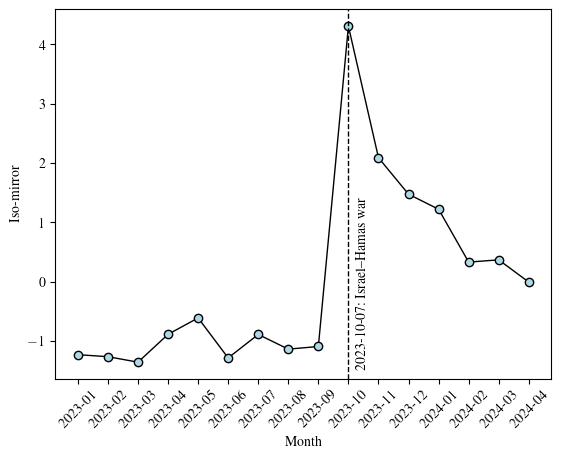

In [15]:
V = dmprdpg.mirror(Y, n_components_cmds=2, n_components_isomap=1, n_neighbors=10)
V2 = np.copy(V)
plt.plot(np.arange(len(V))+1, V, marker='o', color='black', markerfacecolor='lightblue', lw=1)
plt.xticks(np.arange(len(V))+1, labels=map_month[0][subset_times], rotation=45)
# Set xlabel and ylabel
plt.xlabel('Month')
plt.ylabel('Iso-mirror')
## Add vertical line for Israel-Hamas conflict reignited on 7 October 2023 [2023-10]
## x must be where the time is equal to 2023-10 and remove 3 to match the index
plt.axvline(x=np.where(map_month[0] == '2023-10')[0]-2, color='black', linestyle='--', lw=1)
## Add text 'Israel–Hamas war' next to the vertical line
plt.text(np.where(map_month[0] == '2023-10')[0]-2+0.25, -1.5, '2023-10-07: Israel–Hamas war', rotation=90, verticalalignment='bottom')
## Save as PDF
plt.savefig('figures/polecat_isomap_time.pdf', bbox_inches='tight')
plt.show()

Repeat the analysis using `Quad Code Id` for constructing the adjacency matrices:

In [16]:
from scipy.sparse import csr_matrix

# Create the dictionary to hold the sparse matrices
A_dict = {}

# Number of layers
K = 4

# Loop over the unique combinations
for event_month_id in subset_times:
    for quad_id in range(K):
        # Filter the DataFrame for the current combination
        filtered_df = df[(df['Event Month Id'] == event_month_id) & (df['Quad Code Id'] == quad_id)]
        # Create a pivot table
        rows = list(filtered_df['Actor Country Id'])
        columns = list(filtered_df['Recipient Country Id'])
        values = [1.] * len(filtered_df)
        # Convert the pivot table to a sparse matrix
        sparse_matrix = csr_matrix((values, (rows, columns)), shape=(N, N))
        # Add the sparse matrix to the dictionary
        A_dict[(quad_id, event_month_id-3)] = sparse_matrix 

In [17]:
S = dmprdpg.singular_values_A_tilde(A_dict, K=K, T=T, d_max=A_dict[0,0].shape[0]-1)
d = dmprdpg.eigengap(S, x=2)[-1]
print('Estimated dimension:', d)

Estimated dimension: 4


In [18]:
X, Y = dmprdpg.duase(A_dict, K=K, T=T, d=d)

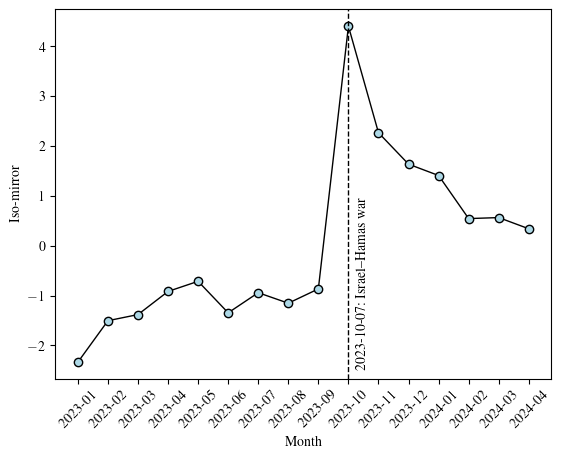

In [19]:
V = dmprdpg.mirror(Y, n_components_cmds=2, n_components_isomap=1, n_neighbors=10)
plt.plot(np.arange(len(V))+1, V, marker='o', color='black', markerfacecolor='lightblue', lw=1)
plt.xticks(np.arange(len(V))+1, labels=map_month[0][subset_times], rotation=45)
# Set xlabel and ylabel
plt.xlabel('Month')
plt.ylabel('Iso-mirror')
## Add vertical line for Israel-Hamas conflict reignited on 7 October 2023 [2023-10]
## x must be where the time is equal to 2023-10 and remove 3 to match the index
plt.axvline(x=np.where(map_month[0] == '2023-10')[0]-2, color='black', linestyle='--', lw=1)
## Add text 'Israel–Hamas war' next to the vertical line
plt.text(np.where(map_month[0] == '2023-10')[0]-2+0.25, -2.5, '2023-10-07: Israel–Hamas war', rotation=90, verticalalignment='bottom')
## Save as PDF
plt.savefig('figures/polecat_isomap_time_quad.pdf', bbox_inches='tight')
plt.show()

In [20]:
## Get PLOVER intensity scores
plover = pd.read_csv('../data/polecat/plover_intensity.csv', header=None)
## Calculate the mean intensity for each value of Quad Code (column index 3)
plover_mean = np.array(plover.groupby(3)[1].mean().reset_index())

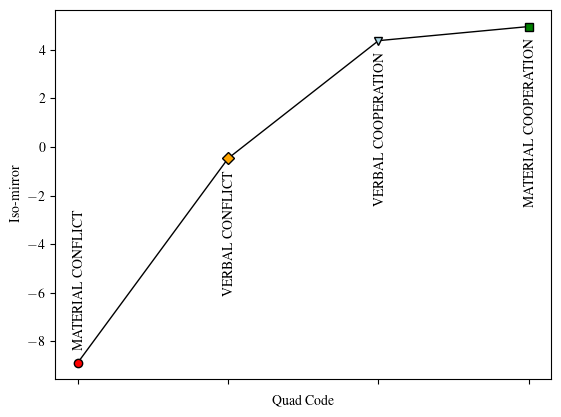

In [21]:
V = dmprdpg.mirror(X, n_components_cmds=2, n_components_isomap=1, n_neighbors=1)
V_vals = np.sort(V[:,0])[::-1]
V_keys = np.array(map_quad_code[0][np.argsort(V[:,0])[::-1]])
V_cols = list(map_quad_code[1][np.argsort(V[:,0])[::-1]])
colours = ['red', 'green', 'orange', 'lightblue']
markers = ['o', 's', 'D', 'v'] 
plt.plot(np.arange(K), -V_vals, color='black', lw=1)
## Plot in the legend 
plt.xticks(np.arange(K), labels=[], rotation=30)
## Add the labels in xticks as text next to the points
for i in range(K):
    plt.plot(i, -V_vals[i], marker=markers[V_cols[i]], color='black', markerfacecolor=colours[V_cols[i]])
    plt.text(i - 0.035, -V_vals[i] - (-0.5 if i == 0 else 0.5), V_keys[i], rotation=90, verticalalignment='bottom' if i==0 else 'top')
# Set xlabel and ylabel
plt.xlabel('Quad Code')
plt.ylabel('Iso-mirror')
## Save as PDF
plt.savefig('figures/polecat_isomap_quad_code.pdf', bbox_inches='tight')
plt.show()

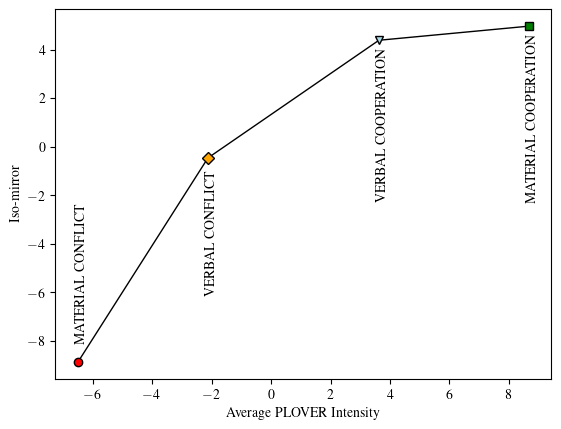

In [22]:
V_plover = plover_mean[:,1][np.argsort(V[:,0])[::-1]]
plt.plot(np.sort(V_plover), -V_vals[np.argsort(V_plover)], color='black', lw=1)
## Add the labels in xticks as text next to the points
V_vals2 = V_vals - np.array([0.75, -0.5, -0.3, -0.3])
V_plover2 = V_plover - np.array([0.1, 0.1, 0.1, 0.1])
for i in range(K):
    plt.plot(V_plover[i], -V_vals[i], marker=markers[V_cols[i]], color='black', markerfacecolor=colours[V_cols[i]])
    plt.text(V_plover2[i], -V_vals2[i], V_keys[i], rotation=90, verticalalignment='bottom' if i==0 else 'top')
# Set xlabel and ylabel
plt.xlabel('Average PLOVER Intensity')
plt.ylabel('Iso-mirror')
# Save as PDF
plt.savefig('figures/polecat_isomap_quad_code_plover.pdf', bbox_inches='tight')
plt.show()

Joint plot for both:

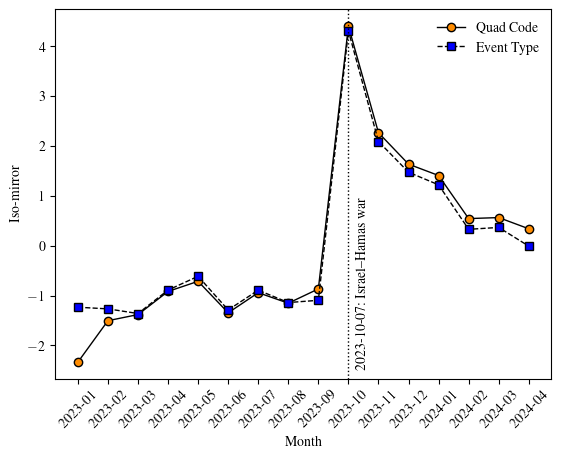

In [23]:
V = dmprdpg.mirror(Y, n_components_cmds=2, n_components_isomap=1, n_neighbors=10)
plt.plot(np.arange(len(V))+1, V, marker='o', color='black', markerfacecolor='darkorange', lw=1)
plt.plot(np.arange(len(V))+1, V2, marker='s', color='black', markerfacecolor='blue', lw=1, linestyle='dashed')
plt.xticks(np.arange(len(V))+1, labels=map_month[0][subset_times], rotation=45)
# Set xlabel and ylabel
plt.xlabel('Month')
plt.ylabel('Iso-mirror')
# Set legend
plt.legend(['Quad Code', 'Event Type'], frameon=False, loc='upper right')
## Add vertical line for Israel-Hamas conflict reignited on 7 October 2023 [2023-10]
## x must be where the time is equal to 2023-10 and remove 3 to match the index
plt.axvline(x=np.where(map_month[0] == '2023-10')[0]-2, color='black', linestyle='dotted', lw=1)
## Add text 'Israel–Hamas war' next to the vertical line
plt.text(np.where(map_month[0] == '2023-10')[0]-2+0.25, -2-0.5, '2023-10-07: Israel–Hamas war', rotation=90, verticalalignment='bottom')
## Save as PDF
plt.savefig('figures/polecat_isomap_time_combined.pdf', bbox_inches='tight')
plt.show()